## VEGETABLES, VISHNU 

In [1]:
from collections import defaultdict, Counter
import json
import numpy as np
import time
import mygrad as mg
import gensim
from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline

import re, string
punc_regex = re.compile('[{}]'.format(re.escape(string.punctuation)))

In [2]:
path = r"./glove.6B.50d.txt.w2v"
glove = KeyedVectors.load_word2vec_format(path, binary=False)

In [39]:
class COCOMappings:
    def __init__(self, glove):
        with open(r'./captions_train2014.json') as json_file:
            self.data = json.load(json_file)
            
        self.glove = glove
            
        self.caption_ids_to_captions = {cap['id']: cap['caption'] for cap in self.data['annotations']}
        self.image_ids_to_urls = {img['id']: img['coco_url'] for img in self.data['images']}
        
        self.img_ids = tuple(cap['image_id'] for cap in self.data['annotations'])
        self.caption_ids = tuple(cap['id'] for cap in self.data['annotations'])
        self.captions = tuple(cap['caption'] for cap in self.data['annotations'])
        
        self.caption_ids_to_embs = self.caption_id_to_emb()
        self.image_id_to_caption_id = self.generate_image_to_caption_id()
    
    def generate_image_to_caption_id(self):
        image_id_to_caption_ids_dict = {}
        
        for cap_dict in self.data['annotations']:
            if cap_dict['image_id'] in image_id_to_caption_ids_dict:
                image_id_to_caption_ids_dict[cap_dict['image_id']].append(cap_dict['id'])
            else:
                image_id_to_caption_ids_dict[cap_dict['image_id']] = [cap_dict['id']]
                
        return image_id_to_caption_ids_dict
        
    def tokenize(self, corpus):
        return punc_regex.sub('', corpus).lower().split()

    def to_df(self, captions):
        
        counter = Counter()
        for caption in captions:
            counter.update(set(self.tokenize(caption)))
        return dict(counter)
    
    
    def to_idf(self, captions):
        """ 
        Given the vocabulary, and the word-counts for each document, computes
        the inverse document frequency (IDF) for each term in the vocabulary.

        Parameters
        ----------
        vocab : Sequence[str]
            Ordered list of words that we care about.

        counters : Iterable[collections.Counter]
            The word -> count mapping for each document.

        Returns
        -------
        numpy.ndarray
            An array whose entries correspond to those in `vocab`, storing
            the IDF for each term `t`: 
                               log10(N / nt)
            Where `N` is the number of documents, and `nt` is the number of 
            documents in which the term `t` occurs.
        """
        vishnu = self.to_df(captions)
        return {word : np.log10(len(captions)/cnt + 1) for word, cnt in vishnu.items()}
    
    def normalize(self, array):
        #sqrroot(sum(vectorsquared))
        return (sum(array ** 2)) ** 0.5
        
        
    def caption_to_emb(self, caption, idfs):
        vishnu = sum(self.glove[word] * idfs[word] for word in self.tokenize(caption) if word in self.glove)
        return vishnu/self.normalize(vishnu)
    
    def caption_id_to_emb(self):
        idfs = self.to_idf(self.captions)
        return {caption_id : self.caption_to_emb(self.caption_ids_to_captions[caption_id], idfs) for caption_id in self.caption_ids}

In [40]:
coco = COCOMappings(glove)

In [7]:
total_imgs = len(coco.img_ids)
train_range = 4*total_imgs//5

In [8]:
ids = np.array(coco.img_ids)
np.random.shuffle(ids)
train = ids[:train_range]
test = ids[train_range:]

In [20]:
def generate_triples(data, model, num_captions, trips_per_cap):
    triples = []
    for i in range(num_captions):
        img_id = np.random.choice(data)
        cap_id = np.random.choice(model.image_id_to_caption_id[img_id])
        cap_emb = model.caption_ids_to_embs[cap_id]
        for n in range(trips_per_cap):
            bad_img_id = generate_bad_img(img_id, cap_emb, model, data)
            triples.append((img_id, cap_id, bad_img_id))
    return triples

In [46]:
def generate_bad_img(img_id, cap_emb, model, data):
    captions = []
    images = []
    for i in range(25):
        id_choice = img_id
        while id_choice == img_id: id_choice = np.random.choice(data)
        images.append(id_choice)
        captions.append(np.random.choice(model.image_id_to_caption_id[id_choice]))
    dots = np.zeros(25)
    for index, cap in enumerate(captions):
        emb = model.caption_ids_to_embs[cap]
        dots[index] = np.matmul(emb, cap_emb)
    max_index = np.argmax(dots)
    #bad_caption_id = captions[max_index]
    bad_img_id = images[max_index]
    return bad_img_id

In [47]:
generate_triples(train, model, 10, 3)

[(503212, 488604, 366956),
 (503212, 488604, 213933),
 (503212, 488604, 148541),
 (327042, 152378, 9774),
 (327042, 152378, 42751),
 (327042, 152378, 30387),
 (105804, 771143, 256655),
 (105804, 771143, 273600),
 (105804, 771143, 500782),
 (85604, 654288, 467232),
 (85604, 654288, 229603),
 (85604, 654288, 268590),
 (267708, 275287, 428576),
 (267708, 275287, 65177),
 (267708, 275287, 220317),
 (274801, 97915, 84879),
 (274801, 97915, 358550),
 (274801, 97915, 1864),
 (28149, 7907, 564431),
 (28149, 7907, 243251),
 (28149, 7907, 6428),
 (143629, 656410, 494462),
 (143629, 656410, 135171),
 (143629, 656410, 301730),
 (296790, 61335, 156042),
 (296790, 61335, 162813),
 (296790, 61335, 44251),
 (120697, 270221, 116353),
 (120697, 270221, 93838),
 (120697, 270221, 538979)]

In [41]:
import io
import requests
from PIL import Image

__all__ = ["download_image"]


def download_image(img_url):
    """ Fetches an image from the web.

    Parameters
    ----------
    img_url : string
        The url of the image to fetch.

    Returns
    -------
    PIL.Image
        The image."""

    response = requests.get(img_url)
    return Image.open(io.BytesIO(response.content))

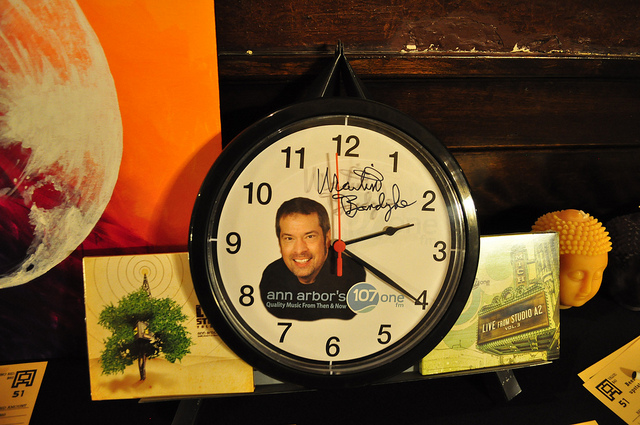

In [51]:
download_image(model.image_ids_to_urls[274801])

In [52]:
print(model.caption_ids_to_captions[97915])

man pictured inside of an old plastic clock


In [45]:
print(model.caption_ids_to_captions[124623])

many people are walking around on some grass


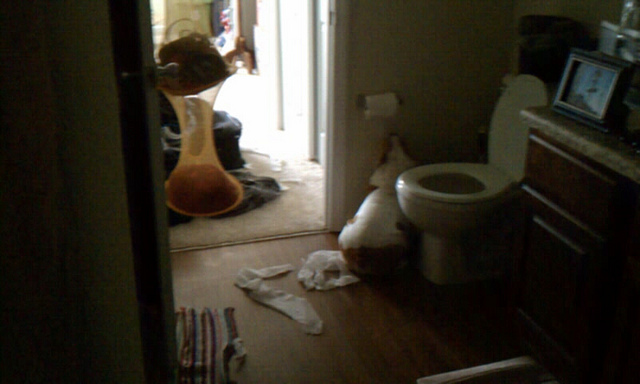

In [53]:
download_image(model.image_ids_to_urls[84879])